<a href="https://colab.research.google.com/github/rklein14-bing/Sandbox/blob/main/Assignment_3A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Author Information
Name: Ryan Klein

B-Number: B00685239

Email: rklein14@binghamton.edu

## General Instructions 
### Due November 11th, 11:59 PM.

In the following assignment, you will be using the deep learning framework, PyTorch, to perform computer vision tasks such as image classification and object detection. This will be a report-style assignment, where you will try multiple different models, optimization algorithms, and hyperparameters, and present your findings in a short report with visualizations inside the notebook.  


Functions and cells that need to be implemented are marked with a bold **implement** keyword or clearly marked in the experiments section. 

The experiments section for each classifier also need to be implemented. You should follow the instructions above the cell. You may also add additional cells. 

Cells marked **run** need to be run to set up the appropriate infrastructure, but do not need to be modified. Make sure you have run the previous cells before running the current cell, or you may get an error.

It is standard practice in ML to share notebooks to discuss the workflow and results in a professional setting. So, the code quality also matters. You should make sure your code is readable and conforms to standard practices. Your figures should be intelligable and include proper axis labels, titles, and legends. Unreadable and poorly written code may result in a points deduction.  

Submission will be via GitHub Classroom. **You are required to have at least 10 commits for this assignment.**

## Uploading and Downloading Data from Colab

Unlike the previous assignments, you will downloading and uploading additional data from and into the Colab environment. 

You can mount directories from your Google Drive and use the session storage for your work. 

[Take a look here for an example notebook on handling data download and upload on Colab. ](https://colab.research.google.com/notebooks/io.ipynb#scrollTo=hauvGV4hV-Mh)

## Import statements

**Run** the cell to import the packages needed for the code below. You may other packages but ask first. 

In [1]:
import torch
import csv
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [2]:
torch.manual_seed(42)  # Set the seed for the random number generator 

## CUDA Runtime

You will want to make use of the GPU runtimes on Colab to speed up your training. You can change your runtime by going to:

`Runtime > Change runtime type` and selecting GPU. 

You will have to explicitly use the send Torch tensors to GPUs, by calling `.cuda()`  on the tensors and modules to utilize them on the GPU.

[Take a look at the quickstart for PyTorch](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html)

## Part 1: Data Handling in PyTorch (20 pts)

### Dataset class

A large part of any machine learning workflow is the proper and efficient handling of data. Datasets are often large, scattered across filesystems, and require transformations and augmentation. Deep learning libraries such as `PyTorch` provide utilities to help in this process. In the next section, you will write a custom MNIST dataset and add data augmentation to your data pipeline for your traininig. 

**Run** the following cell to define some helper functions to load the MNIST data.

In [3]:
def _data_parser_helper(csv_file_name):
  '''
  Reads CSV file and converts it into numpy arrays.

  Args:
    csv_file_name (string): String of the path of csv file. 

  Returns:
    (np.array(float), np.array(int)): Returns a tuple of numpy arrays. 
  '''
  X = []
  Y = []
  with open(csv_file_name,'r') as _file:
      csv_reader = csv.reader(_file, delimiter=",")
      for row in csv_reader:
          Y.append(int(row[0]))
          X.append([float(i)/255.0 for i in row[1:]])
  return (np.array(X), np.array(Y))

def get_mnist_train_data():
  X_train, Y_train = _data_parser_helper("sample_data/mnist_train_small.csv")
  return X_train, Y_train

def get_mnist_test_data():
  X_test, Y_test = _data_parser_helper("sample_data/mnist_test.csv")
  return X_test, Y_test

***Implement*** the `MNIST` class to serve as a container for our PyTorch MNIST data. [Take a look at this tutorial on PyTorch datasets, dataloading, and transforms.](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class)
[This second, more important tutorial specifically covers custom datasets and dataloaders.](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files)

The MNIST data on Colab is pre-installed on all notebooks as a CSV.
Your class must read the data and store it as PyTorch float tensors. 
Use the helper functions above (already written) to read the data,
which will return the data as NumPy arrays.

You should implement:

- `__init__()` to read the appropriate CSV file, and store it in the class as a `torch.Tensor` with float dtype. 
- `__len__()` to return the number of samples in the dataset. 
- `__getitem__(i)` to return the i-th sample and label from the data you have stored. 

In [4]:
class MNIST(Dataset):
  """MNIST custom dataset that reads the CSV file and transforms them into PyTorch Tensors"""

  def __init__(self, is_training=True, transform=None):
    """
    Args:
      is_training (bool): If true loads 
        the training dataset. If false, loads the test dataset. 
        Use the functions above.
      transform (callable): Transform to be applied on a sample.
        These will be used for data augmentations.
    """
    if is_training:
      x, y = get_mnist_train_data()
    else:
      x, y = get_mnist_test_data()
    self.images = torch.from_numpy(x).float()
    self.labels = torch.from_numpy(y)
    self.transform = transform

  def __len__(self):
    """Returns the size (the number of samples) of the dataset.
    """
    return len(self.images)

  def __getitem__(self, i):
    """Returns the i-th sample and label and applies any transforms defined.

      Args:
        i (int): The index of sample in the data array to retrieve. 
    """
    image = self.images[i]
    if self.transform:
      image = torch.reshape(image, (1,28,28))
      image = self.transform(image)
      image = torch.flatten(image[0, :, :])
    return image, self.labels[i]
  

***Implement*** the following cell to visualize the data in the dataset. Use `Matplotlib` or your favorite visualization package to plot 5 images of each class in a single figure. 

You should initialize a MNIST dataset object for the training class. Visualize this dataset. This will not be used in the future.  



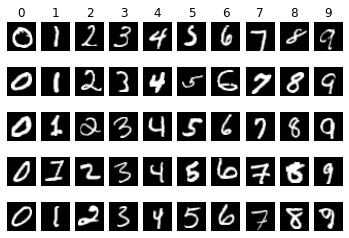

In [5]:
def visualize(dataset):
  num_classes = 10
  samples_per_class = 5
  for cls in range(num_classes):
      for samp in range(samples_per_class):
          idx = torch.randint(len(dataset), size=(1,)).item()
          # Inefficient, clean up later
          while dataset[idx][1] != cls:
            idx = torch.randint(len(dataset), size=(1,)).item()
          plt_idx = samp * num_classes + cls + 1
          im, label = dataset[idx]
          plt.subplot(samples_per_class, num_classes, plt_idx)
          plt.imshow(im.squeeze().reshape(28,28), cmap='gray')
          plt.axis('off')
          if samp == 0:
              plt.title(cls)
  plt.show()

dataset = MNIST()
visualize(dataset)

***Implement***
the following cell to create a PyTorch transform object and
assign it to a variable.
You may name the variable whatever you wish;
you will use the object to construct train and test MNIST datasets.

You will use the transformations defined in `torchvision`,
which can be found [here](https://pytorch.org/vision/stable/transforms.html#transforms-on-pil-image-and-torch-tensor).

Add the `RandomRotation` and `Normalize` transformations to the dataset. You will need to [compose the two transforms](https://pytorch.org/vision/0.9/transforms.html#torchvision.transforms.Compose). Restrict the rotations to +/- 15 degrees. 

The mean and standard deviation of the training set is 0.13 and 0.31 respectively.

At the end of the cell, construct a training and test dataset.
Name these carefully, these datasets will be used in the next sections.

In [64]:
transform_obj = transforms.Compose([
  transforms.RandomRotation(15),
  transforms.Normalize(0.13, 0.31),
])

train_dataset = MNIST(True, transform_obj)
test_dataset = MNIST(False, transform_obj)

***Implement*** the following cell to visualize the data in the dataset with the transformations similar to the previous visualization. 

Training dataset with tranformations:


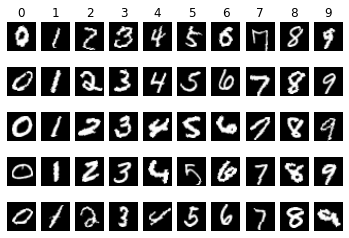

Test dataset with tranformations:


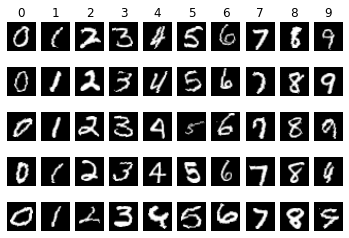

In [7]:
print("Training dataset with tranformations:")
visualize(train_dataset)
print("Test dataset with tranformations:")
visualize(test_dataset)

***Implement*** the following cell to randomly split the training dataset previously defined, and make a training and validation set. Do an 80-20 split for the training and validation set. Name these sets carefully, they will be used in the next section to train your models. 

You can use the utilities in `torch.utils.data`.

In [8]:
train_num = int(len(train_dataset) * 0.8)
val_num = len(train_dataset) - train_num
train_set, val_set = torch.utils.data.random_split(train_dataset, [train_num, val_num])
print(f"Number of train samples: {len(train_set)}")
print(f"Number of validation samples: {len(val_set)}")

Number of train samples: 16000
Number of validation samples: 4000


## Part 2: MNIST Classification (40 pts)

### Linear Classifiers

The linear classifiers you implemented in the last assignment will serve as our baseline for more powerful convolutional neural networks. You will ***implement*** the multi-class SVM and  Softmax classifiers in the following cells.  

**Implement** a LinearSVM classifier in the following cell. Your implementation should be a python class that inherits from `torch.nn.Module`. 

You should use classes and functions defined in `torch.nn` and `torch.nn.Functional`.   

In [9]:
class LinearSVM(nn.Module):
  ''' Implements the linear SVM using Torch.
  '''
  def __init__(self, num_classes, *args, **kwargs):
    '''
      num_classes (int): The number of output classes
    '''
    super(LinearSVM, self).__init__()
    self.num_classes = num_classes
    self.lin1 = nn.Linear(784, num_classes)
    
    # Define the loss function
    self.loss_function = nn.MultiMarginLoss()


  def forward(self, x):
    '''
      x (torch.Tensor): Input image as a torch tensor. 
    '''
    x = self.lin1(x)
    #x = self.act1(x)
    #x = self.lin2(x)
    return x

    

***Implement*** using any PyTorch defined optimizer, code to train your LinearSVM classifier on the training dataset. You will want to try different optimizers, learning rates, and batch sizes. 

PyTorch provides implementations of various optimization algorithms in the `torch.optim` package. You can use any of the first order methods such as:

- SGD (with or without momentum)
- AdaDelta
- ADAM
- RProp
- RMSProp

***Note:*** You should keep track of the performance of the optimizers, batch sizes, and learning rates. You should justify the choice of your hyperparameters in the report at the end of this section. You will be asked to quantify and visualize the differences between these hyperparameters. 

You should use `Torch.utils.data.DataLoader` to do the data loading. Make sure to use the correct loss function. You may use the predefined loss functions available in `Torch.nn`.

***Note:*** As the optimization procedure for training different models is often the same, you should write helper functions that are reusable. This will make your code more readable and reduce the possibility of unexpected bugs.  

To train a single model, you will need to:

- Iterate through the data in batches using your training or validation dataloader
- Perform the forward pass
- Compute the loss
- Perform the backward pass
- Take an optimizer step
- Repeat the process till network converges or some other criterion
- Every n iterations, go through the validation set and calculate the loss and accuracy of the validation set to check your training performance

In [10]:
import time
def train_classifier(model_type, config):
  run_on_gpu = torch.cuda.is_available()
  print("Running on {}".format("GPU" if run_on_gpu else "CPU"))
  results = {}
  iter = 0
  model = model_type(10)
  if run_on_gpu:
    model.cuda()
  iter += 1
  training_loader = DataLoader(train_set, config['BatchSize'], pin_memory=True, prefetch_factor=2)
  validation_loader = DataLoader(val_set, config['BatchSize'], pin_memory=True, prefetch_factor=2)
  optimizer = config['Opt'](model.parameters(), **config['OptParams'])
  num_epochs = 0
  accuracy, accuracy_last = 0, 0
  start = time.time()
  epoch_validations = []
  #print("EPOCH: ", end="")
  while num_epochs < 5 or accuracy - accuracy_last > 0.003:
    #print("BEFORE LOADER")
    # sum_trains = 0.0
    # sum_loads = 0.0
    for batch_idx, (data, label) in enumerate(training_loader):
        #start_train = time.time()
        # if batch_idx == 0:
        #   print("START TRAIN")
        # else:
        #   sum_loads += start_train - end_train
        if run_on_gpu:
          data = data.cuda()
          label = label.cuda()
        scores = model(data)
        loss = model.loss_function(scores, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # end_train = time.time()
        # sum_trains += end_train - start_train
    #print(f"SUM TRAINS={sum_trains}; SUM LOADS={sum_loads}")
    total_loss = 0
    correct = 0
    for data, label in validation_loader:
      if run_on_gpu:
        data = data.cuda()
        label = label.cuda()
      scores = model(data)
      loss = model.loss_function(scores, label)
      total_loss += loss
      correct += int(torch.sum(torch.argmax(scores, 1) == label))
    accuracy_last = accuracy
    accuracy = correct/len(val_set) * 100.0
    num_epochs += 1
    epoch_validations.append(accuracy)
    print(num_epochs, end=" ")
    #print(f"Hyperparam num: {iter}; accuracy on validation set: {accuracy}; epochs: {num_epochs}; Time:{time.time() - start}")
  # Record stats
  print()
  results['BatchSize'] = config['BatchSize']
  results['TimePerEpoch'] = (time.time() - start) / float(num_epochs)
  results['NumEpochs'] = num_epochs
  results['Validation'] = epoch_validations
  if 'lr' in config['OptParams']:
    results['LearnRate'] = config['OptParams']['lr']

  return model, results


In [75]:
def get_test_accuracy(model, test_dataset, conv=False):
  batch_size = len(test_dataset)
  test_loader = DataLoader(test_dataset, batch_size, pin_memory=True, prefetch_factor=2)
  correct = 0
  for data, label in test_loader:
      if torch.cuda.is_available():
        data = data.cuda()
        label = label.cuda()
      if conv:
        data = data.reshape(batch_size, 1, 28, 28)
      scores = model(data)
      correct += int(torch.sum(torch.argmax(scores, 1) == label))
  return correct/len(test_dataset) * 100.0

In [12]:
def hyper_param_loops(model, loops=1):
  # Check impacts of batch size
  batch_size_results = []
  hyper_params = {'Opt': torch.optim.Adam, 'OptParams': {'lr': 5e-3, 'amsgrad': True}}
  for multiplier in range(1, loops+1):
    hyper_params['BatchSize'] = 25 * multiplier
    print(f"Testing batch size: {hyper_params['BatchSize']}")
    model, results = train_classifier(LinearSVM, hyper_params)
    accuracy = get_test_accuracy(model, test_dataset)
    results['TestAccuracy'] = accuracy
    print(accuracy)
    batch_size_results.append(results)
  # Check impacts of learning rate
  LearnRateResults = []
  hyper_params = {'BatchSize': 125, 'Opt': torch.optim.Adam, 'OptParams': {'lr': 1e-5, 'amsgrad': True}}
  for multiplier in range(1, loops+1):
    hyper_params['OptParams']['lr'] = (1e-5 * 2 ** multiplier)
    print(f"Learning rate: {hyper_params['OptParams']['lr']}")
    model, results = train_classifier(LinearSVM, hyper_params)
    accuracy = get_test_accuracy(model)
    results['TestAccuracy'] = accuracy
    LearnRateResults.append(results)
  # Check the impacts of different optimizers
  hyper_params_opt = [                                                         
    {'Opt': torch.optim.Adam, 'OptParams': {'lr': 3.2e-4}, 'Label': 'Adam'},                   
    {'Opt': torch.optim.Adam, 'OptParams': {'lr': 3.2e-4, 'amsgrad': True}, 'Label': 'Adam-asmgrad'},  
    {'Opt': torch.optim.AdamW, 'OptParams': {'lr': 3.2e-4}, 'Label': 'AdamW'},                 
    {'Opt': torch.optim.AdamW, 'OptParams': {'lr': 3.2e-4, 'amsgrad': True}, 'Label': 'AdamW-asmgrad'}, 
    {'Opt': torch.optim.SGD, 'OptParams': {'lr': 3.2e-4}, 'Label': 'SGD'},                    
    {'Opt': torch.optim.SGD, 'OptParams': {'lr': 3.2e-4, 'momentum': 0.5}, 'Label': 'SGD-0.5'},   
    {'Opt': torch.optim.SGD, 'OptParams': {'lr': 3.2e-4, 'momentum': 0.99}, 'Label': 'SGD-0.99'}, 
    {'Opt': torch.optim.Rprop, 'OptParams': {}, 'Label': 'Rprop'},                          
  ]
  OptResults = []
  for hyper_params in hyper_params_opt:
    hyper_params['BatchSize'] = 125
    model, results = train_classifier(LinearSVM, hyper_params)
    accuracy = get_test_accuracy(model)
    results['TestAccuracy'] = accuracy
    results['Label'] = hyper_params['Label']
    OptResults.append(results)
  return {'BatchSizeResults': batch_size_results, 
          'LearnRateResults': LearnRateResults, 
          'OptResults': OptResults}


In [ ]:
results_svm = hyper_param_loops(LinearSVM, 8)

# Saved results for SVM
hyper_params = [                                                                            # Accuracy  Epochs  Time
  {'BatchSize': 128, 'Opt': torch.optim.Adam, 'OptParams': {'lr': 1e-4}},                   # 86.22     9       81
  {'BatchSize': 128, 'Opt': torch.optim.Adam, 'OptParams': {'lr': 5e-3}},                   # 86.20     6       54
  {'BatchSize': 128, 'Opt': torch.optim.Adam, 'OptParams': {'lr': 1e-2}},                   # 85.65     5       46
  {'BatchSize': 128, 'Opt': torch.optim.Adam, 'OptParams': {'lr': 5e-3, 'amsgrad': True}},  # 85.57     9       89
  {'BatchSize': 128, 'Opt': torch.optim.AdamW, 'OptParams': {'lr': 5e-3,}},                 # 86.53     6       53
  {'BatchSize': 128, 'Opt': torch.optim.AdamW, 'OptParams': {'lr': 5e-3, 'amsgrad': True}}, # 86.28     5       50
  {'BatchSize': 128, 'Opt': torch.optim.SGD, 'OptParams': {'lr': 1e-4}},                    # 62.8      14      130
  {'BatchSize': 128, 'Opt': torch.optim.SGD, 'OptParams': {'lr': 1e-3, 'momentum': 0.5}},   # 84.70     12      104
  {'BatchSize': 128, 'Opt': torch.optim.SGD, 'OptParams': {'lr': 1e-5, 'momentum': 0.99}},  # 81.03     10      93
  {'BatchSize': 128, 'Opt': torch.optim.SGD, 'OptParams': {'lr': 1e-2, 'momentum': 0.99}},  # 87.75     6       54
  {'BatchSize': 128, 'Opt': torch.optim.Rprop, 'OptParams': {}},                            # 84.90     5       14
  {'BatchSize': 64, 'Opt': torch.optim.Rprop, 'OptParams': {}},                             # 83.35     6       53
  {'BatchSize': 4, 'Opt': torch.optim.Rprop, 'OptParams': {}},                              # 67.10     6       74
]

Testing batch size: 25
Running on GPU


/usr/local/lib/python3.7/dist-packages/torch/autograd/__init__.py:175: UserWarning: An output with one or more elements was resized since it had shape [], which does not match the required output shape [25, 10]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:17.)
  allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to run the backward pass


1 2 3 4 5 6 
84.97
Testing batch size: 50
Running on GPU


/usr/local/lib/python3.7/dist-packages/torch/autograd/__init__.py:175: UserWarning: An output with one or more elements was resized since it had shape [], which does not match the required output shape [50, 10]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:17.)
  allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to run the backward pass


1 2 3 4 5 6 
84.68
Testing batch size: 75
Running on GPU


/usr/local/lib/python3.7/dist-packages/torch/autograd/__init__.py:175: UserWarning: An output with one or more elements was resized since it had shape [], which does not match the required output shape [75, 10]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:17.)
  allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to run the backward pass


1 2 3 4 5 
84.96000000000001
Testing batch size: 100
Running on GPU


/usr/local/lib/python3.7/dist-packages/torch/autograd/__init__.py:175: UserWarning: An output with one or more elements was resized since it had shape [], which does not match the required output shape [100, 10]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:17.)
  allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to run the backward pass


1 2 3 4 5 6 
86.49
Testing batch size: 125
Running on GPU


/usr/local/lib/python3.7/dist-packages/torch/autograd/__init__.py:175: UserWarning: An output with one or more elements was resized since it had shape [], which does not match the required output shape [125, 10]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:17.)
  allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to run the backward pass


1 2 3 4 5 6 7 8 
85.72
Testing batch size: 150
Running on GPU


/usr/local/lib/python3.7/dist-packages/torch/autograd/__init__.py:175: UserWarning: An output with one or more elements was resized since it had shape [], which does not match the required output shape [150, 10]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:17.)
  allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to run the backward pass


1 2 3 4 5 
86.58
Testing batch size: 175
Running on GPU


/usr/local/lib/python3.7/dist-packages/torch/autograd/__init__.py:175: UserWarning: An output with one or more elements was resized since it had shape [], which does not match the required output shape [175, 10]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:17.)
  allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to run the backward pass


1 2 3 4 5 
85.83
Testing batch size: 200
Running on GPU


/usr/local/lib/python3.7/dist-packages/torch/autograd/__init__.py:175: UserWarning: An output with one or more elements was resized since it had shape [], which does not match the required output shape [200, 10]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:17.)
  allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to run the backward pass


1 2 3 4 5 
87.53
Learning rate: 2e-05
Running on GPU
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 
Learning rate: 4e-05
Running on GPU
1 2 3 4 5 6 7 8 9 
Learning rate: 8e-05
Running on GPU
1 2 3 4 5 6 7 8 9 
Learning rate: 0.00016
Running on GPU
1 2 3 4 5 6 7 8 9 10 11 12 13 
Learning rate: 0.00032
Running on GPU
1 2 3 4 5 6 7 
Learning rate: 0.00064
Running on GPU
1 2 3 4 5 
Learning rate: 0.00128
Running on GPU
1 2 3 4 5 
Learning rate: 0.00256
Running on GPU
1 2 3 4 5 
Running on GPU
1 2 3 4 5 6 7 8 
Running on GPU
1 2 3 4 5 
Running on GPU
1 2 3 4 5 6 
Running on GPU
1 2 3 4 5 6 
Running on GPU
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 
Running on GPU
1 2 3 4 5 6 7 8 9 10 11 12 13 
Running on GPU
1 2 3 4 5 
Running on GPU
1 2 3 4 5 6 7 


**Implement** a Softmax classifier in the following cell. Your implementation should be a python class that inherits from `torch.nn.Module`. 

In [11]:
class SoftmaxClassifier(nn.Module):
  ''' Implements the linear SVM using Torch.
  '''
  def __init__(self, num_classes, *args, **kwargs):
    '''
      num_classes (int): The number of output classes
    '''
    super().__init__()
    self.num_classes = num_classes
    self.lin1 = nn.Linear(784, num_classes)
    
    # Define the loss function
    self.loss_function = nn.CrossEntropyLoss()


  def forward(self, x):
    '''
      x (torch.Tensor): Input image as a torch tensor. 
    '''
    x = self.lin1(x)
    #x = self.act1(x)
    #x = self.lin2(x)
    return x

    

***Implement*** using any PyTorch defined optimizer, train your Softmax classifier on the training dataset and validate on the validation dataset, as you did before. 

***Note:*** You should keep track of the performance of the optimizers, batch sizes, and learning rates. You should justify the choice of your hyperparameters in the report at the end of this section. You will be asked to quantify and visualize the differences between these hyperparameters.

You will want to try different optimizers, learning rates, and batch sizes. You should use `Torch.DataLoader` to simplify the data loading. Make sure to use the correct loss function. You may use predefined loss functions available in `Torch.nn`.

Same as before, to train a single model, you will need to:

- Iterate through the data in batches using your training or validation dataloader
- Perform the forward pass
- Compute the loss
- Perform the backward pass
- Take an optimizer step
- Repeat the process till network converges or some other criterion
- Every n iterations, go through the validation set and calculate the loss and accuracy of the validation set to check your training performance

In [ ]:
results_softmax = hyper_param_loops(SoftmaxClassifier, loops=8)

# hyper_params = [                                                                            # Accuracy  Epochs  Time
#   {'BatchSize': 128, 'Opt': torch.optim.Adam, 'OptParams': {'lr': 1e-4}},                   # 86.22     9       81
#   {'BatchSize': 128, 'Opt': torch.optim.Adam, 'OptParams': {'lr': 5e-3}},                   # 86.20     6       54
#   {'BatchSize': 128, 'Opt': torch.optim.Adam, 'OptParams': {'lr': 1e-2}},                   # 85.65     5       46
#   {'BatchSize': 128, 'Opt': torch.optim.Adam, 'OptParams': {'lr': 5e-3, 'amsgrad': True}},  # 85.57     9       89
#   {'BatchSize': 128, 'Opt': torch.optim.AdamW, 'OptParams': {'lr': 5e-3,}},                 # 86.53     6       53
#   {'BatchSize': 128, 'Opt': torch.optim.AdamW, 'OptParams': {'lr': 5e-3, 'amsgrad': True}}, # 86.28     5       50
#   {'BatchSize': 128, 'Opt': torch.optim.SGD, 'OptParams': {'lr': 1e-4}},                    # 62.8      14      130
#   {'BatchSize': 128, 'Opt': torch.optim.SGD, 'OptParams': {'lr': 1e-3, 'momentum': 0.5}},   # 84.70     12      104
#   {'BatchSize': 128, 'Opt': torch.optim.SGD, 'OptParams': {'lr': 1e-5, 'momentum': 0.99}},  # 81.03     10      93
#   {'BatchSize': 128, 'Opt': torch.optim.SGD, 'OptParams': {'lr': 1e-2, 'momentum': 0.99}},  # 87.75     6       54
#   {'BatchSize': 128, 'Opt': torch.optim.Rprop, 'OptParams': {}},                            # 84.90     5       14
#   {'BatchSize': 64, 'Opt': torch.optim.Rprop, 'OptParams': {}},                             # 83.35     6       53
#   {'BatchSize': 4, 'Opt': torch.optim.Rprop, 'OptParams': {}},                              # 67.10     6       74
# ]

Testing batch size: 25
Running on GPU


/usr/local/lib/python3.7/dist-packages/torch/autograd/__init__.py:175: UserWarning: An output with one or more elements was resized since it had shape [], which does not match the required output shape [25, 10]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:17.)
  allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to run the backward pass


1 2 3 4 5 6 
85.06
Testing batch size: 50
Running on GPU


/usr/local/lib/python3.7/dist-packages/torch/autograd/__init__.py:175: UserWarning: An output with one or more elements was resized since it had shape [], which does not match the required output shape [50, 10]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:17.)
  allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to run the backward pass


1 2 3 4 5 
85.57000000000001
Testing batch size: 75
Running on GPU


/usr/local/lib/python3.7/dist-packages/torch/autograd/__init__.py:175: UserWarning: An output with one or more elements was resized since it had shape [], which does not match the required output shape [75, 10]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:17.)
  allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to run the backward pass


1 2 3 4 5 6 
85.47
Testing batch size: 100
Running on GPU


/usr/local/lib/python3.7/dist-packages/torch/autograd/__init__.py:175: UserWarning: An output with one or more elements was resized since it had shape [], which does not match the required output shape [100, 10]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:17.)
  allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to run the backward pass


1 2 3 4 5 6 
86.33
Testing batch size: 125
Running on GPU


/usr/local/lib/python3.7/dist-packages/torch/autograd/__init__.py:175: UserWarning: An output with one or more elements was resized since it had shape [], which does not match the required output shape [125, 10]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:17.)
  allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to run the backward pass


1 2 3 4 5 6 7 
86.32
Testing batch size: 150
Running on GPU


/usr/local/lib/python3.7/dist-packages/torch/autograd/__init__.py:175: UserWarning: An output with one or more elements was resized since it had shape [], which does not match the required output shape [150, 10]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:17.)
  allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to run the backward pass


1 2 3 4 5 6 7 
87.36
Testing batch size: 175
Running on GPU


/usr/local/lib/python3.7/dist-packages/torch/autograd/__init__.py:175: UserWarning: An output with one or more elements was resized since it had shape [], which does not match the required output shape [175, 10]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:17.)
  allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to run the backward pass


1 2 3 4 5 6 7 8 
87.36
Testing batch size: 200
Running on GPU


/usr/local/lib/python3.7/dist-packages/torch/autograd/__init__.py:175: UserWarning: An output with one or more elements was resized since it had shape [], which does not match the required output shape [200, 10]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:17.)
  allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to run the backward pass


1 2 3 4 5 6 7 8 
86.87
Learning rate: 2e-05
Running on GPU
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 
Learning rate: 4e-05
Running on GPU
1 2 3 4 5 6 7 8 9 10 11 12 13 14 
Learning rate: 8e-05
Running on GPU
1 2 3 4 5 6 7 8 9 
Learning rate: 0.00016
Running on GPU
1 2 3 4 5 6 7 
Learning rate: 0.00032
Running on GPU
1 2 3 4 5 6 7 8 
Learning rate: 0.00064
Running on GPU
1 2 3 4 5 6 7 8 
Learning rate: 0.00128
Running on GPU
1 2 3 4 5 6 
Learning rate: 0.00256
Running on GPU
1 2 3 4 5 6 
Running on GPU
1 2 3 4 5 6 7 
Running on GPU
1 2 3 4 5 6 7 
Running on GPU
1 2 3 4 5 6 7 8 
Running on GPU
1 2 3 4 5 6 7 
Running on GPU
1 2 3 4 5 6 7 8 9 10 
Running on GPU
1 2 3 4 5 6 7 8 9 10 11 12 
Running on GPU
1 2 3 4 5 6 7 8 
Running on GPU
1 2 3 4 5 6 


***Implement*** visualizations in the following cell to show performance differences of the different hyperparameters. 

***Include*** visualizations for the effect of different batch sizes, learning rates, and optimizers. You are free to choose any method of visualization as long as it is able to succintly convey your justifications.

In [13]:
# Visual results
def visualize_results(classifier_results):
  # Effect of batch size
  print("BATCH SIZE")
  batch_sizes = [results['BatchSize'] for results in classifier_results['BatchSizeResults']]
  time_per_epoch = [results['TimePerEpoch'] for results in classifier_results['BatchSizeResults']]
  test_accuracy = [results['TestAccuracy'] for results in classifier_results['BatchSizeResults']]

  fig, ax = plt.subplots()

  ax.plot(batch_sizes,time_per_epoch, label='Epoch Time', color='blue')
  plt.title('Batch Size')
  ax.set_ylim([0, 15])
  ax.set_ylabel("Time per epoch (sec) - BLUE")
  ax.set_xlabel("Batch size")

  ax2 = ax.twinx()
  ax2.plot(batch_sizes, test_accuracy, label="Accuracy", color='red')
  ax2.set_ylim([80, 100])
  ax2.set_ylabel("Accuracy (%) - RED")
  plt.show()

  # Effect of learning rate
  print("LEARNING RATE")
  learn_rate = [results['LearnRate'] for results in classifier_results['LearnRateResults']]
  num_epochs = [results['NumEpochs'] for results in classifier_results['LearnRateResults']]
  test_accuracy = [results['TestAccuracy'] for results in classifier_results['LearnRateResults']]

  fig, ax = plt.subplots()

  ax.plot(learn_rate,num_epochs, label='Num Epochs', color='blue')
  plt.title('Learning Rate')
  ax.set_ylim([0, 15])
  ax.set_ylabel("Number epochs - BLUE")
  ax.set_xlabel("Learning Rate")

  ax2 = ax.twinx()
  ax2.plot(learn_rate, test_accuracy, label="Accuracy", color='red')
  ax2.set_ylim([80, 100])
  ax2.set_ylabel("Accuracy (%) - RED")
  plt.show()

  # Effect optimizer
  print("OPTIMIZER")
  plt.title("Optimizer")
  plt.ylabel('Accuracy')
  plt.xlabel('Optimizer')
  plt.ylim([60, 90])
  labels = [results['Label'] for results in classifier_results['OptResults']]
  test_accuracy = [results['TestAccuracy'] for results in classifier_results['OptResults']]
  plt.bar(labels, test_accuracy)
  plt.rcParams["figure.figsize"] = (12,6)
  plt.show()


BATCH SIZE


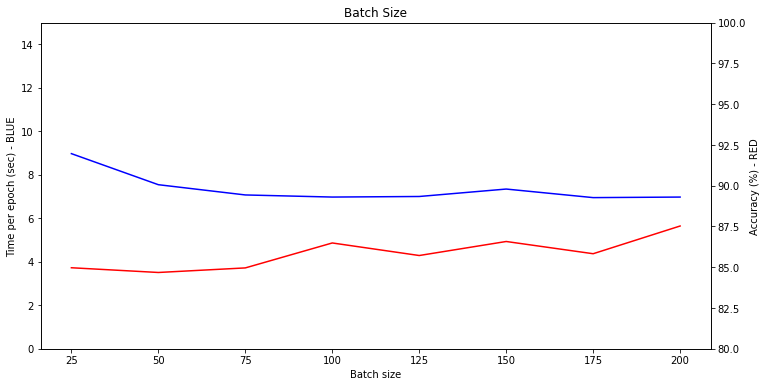

LEARNING RATE


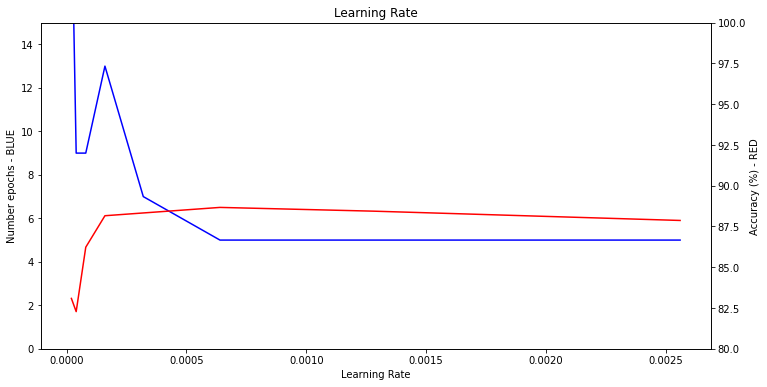

OPTIMIZER


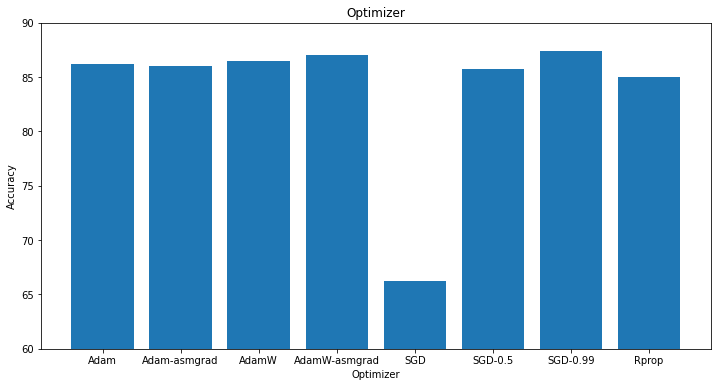

In [ ]:
visualize_results(results_svm)

BATCH SIZE


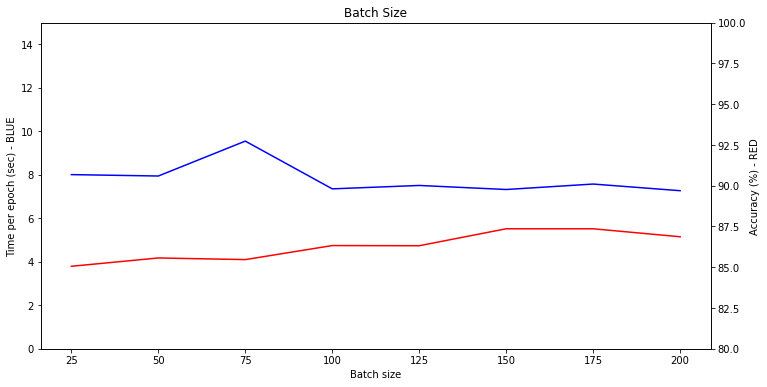

LEARNING RATE


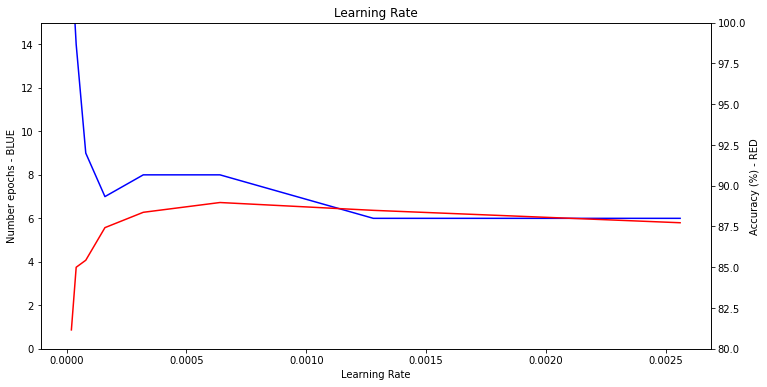

OPTIMIZER


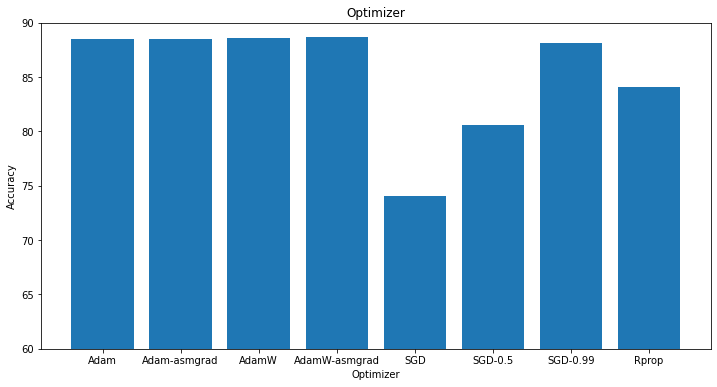

In [ ]:
visualize_results(results_softmax)

### Convolutional Neural Networks

***Implement*** the following cell to implement a convolutional neural network. Similar to before, your implementation should be a Python class that inherits from `torch.nn.Module`. 

Your model can use any of the building blocks defined in `torch.nn` including but not limited to:

- Conv2D
- Linear
- Activation layers:
  - ReLU
  - Tanh
  - Sigmoid
  - Softmax
- Normalization layers:
  - BatchNorm
  - LayerNorm
  - GroupNorm
- Pooling layers:
  - MaxPool
  - AvgPool
- Dropout

Make sure to chose the correct dimensional versions of the layers, i.e for images use MaxPool2d and vectors use MaxPool1d



Example LeNet implementation: 

```python
class LeNet(nn.Module):

    def __init__(self, num_classes=10):
        super(LeNet, self).__init__()
        
        # num_classes number of output classes
        self.num_classes = num_classes
        # 1 input image channel, 
        # 6 output channels
        # 5x5 square convolution kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        # ReLU activation function
        self.act1 = nn.ReLU()
        # Max pooling with 2x2 square kernel
        self.pool1 = nn.MaxPool2d(2)
        
        # Second convolution with 6 input image channels
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)

        # 3 Layer fully connected layer
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.act3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.act4 = nn.ReLU()
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        
        # First Convolution -> Activation -> Max Pooling
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)

        # Second Convolution -> Activation -> Max Pooling
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)

        # flatten all dimensions except the batch dimension
        x = torch.flatten(x, 1) 

        # Three layer MLP with ReLU activations 
        x = self.act3(self.fc1(x))
        x = self.act4(self.fc2(x))
        x = self.fc3(x)

        return x

```

In [57]:
class CNN(nn.Module):
  ''' Implements a CNN using Torch.
  '''
  def __init__(self, num_classes, *args, **kwargs):
    '''
      num_classes (int): The number of output classes
    '''
    super(CNN, self).__init__()

    # Shape: (BATCH_SIZE, 1, 28, 28)
    # Shape after conv = side_len - kernel_size + 1
    
    # First conv layer
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=5)
    # Shape: (BATCH_SIZE, 6, 24, 24)
    # Shape: (BATCH_SIZE, 6, 24, 24)
    self.act1 = nn.ReLU()
    # Shape: (BATCH_SIZE, 6, 24, 24)
    self.pool1 = nn.MaxPool2d(2)
    # Shape: (BATCH_SIZE, 6, 12, 12)

    # Second convolution with 6 input image channels
    self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5)
    self.bn = nn.BatchNorm2d(num_features=24)
    # Shape: (BATCH_SIZE, 16, 8, 8)
    self.act2 = nn.ReLU()
    # Shape: (BATCH_SIZE, 16, 8, 8)
    self.pool2 = nn.MaxPool2d(2)
    # Shape: (BATCH_SIZE, 16, 4, 4)

    # Fully connected layers
    self.fc1 = nn.Linear(in_features=24*4*4, out_features=96)
    self.act3 = nn.ReLU()
    self.fc2 = nn.Linear(96, 84)
    self.act4 = nn.Sigmoid()
    self.fc3 = nn.Linear(in_features=84, out_features=num_classes)

  def forward(self, x):
    '''
      x (torch.Tensor): Input image as a torch tensor. 
    '''
    # First Convolution -> Activation -> Max Pooling
    x = self.conv1(x)
    #x = self.bn1(x)
    x = self.act1(x)
    x = self.pool1(x)

    # Second Convolution -> Activation -> Max Pooling
    x = self.conv2(x)
    x = self.bn(x)
    x = self.act2(x)
    x = self.pool2(x)

    # flatten all dimensions except the batch dimension
    x = torch.flatten(x, 1) 

    # Three layer MLP with ReLU activations 
    x = self.act3(self.fc1(x))
    x = self.act4(self.fc2(x))
    x = self.fc3(x)

    return x
    

In the following cells, perform experiments using the CNN you defined. You may need to reshape your data in order to 2D convolutions. 

Your objective is to find the best architecture that minimizes the error but using as few a parameters and FLOPS as possible. 

***Performance matters!*** The model with the best combination of high accuracy, parameter, and compute efficiency will get extra credit (15 pts).

In [68]:
import time
def train_cnn_classifier(model_type, config, max_epochs, train_set, val_set, starting_model=None):
  run_on_gpu = torch.cuda.is_available()
  if starting_model:
    model = starting_model
  else:
    model = model_type(10)
  if run_on_gpu:
    model.cuda()
  training_loader = DataLoader(train_set, config['BatchSize'])
  validation_loader = DataLoader(val_set, config['BatchSize'])
  optimizer = config['Opt'](model.parameters(), **config['OptParams'])
  num_epochs = 0
  accuracy, accuracy_last = 0, 0
  start = time.time()
  while num_epochs < 3 or (accuracy - accuracy_last > 0.003 and num_epochs <= max_epochs):
    for data, label in training_loader:
      if len(data) == config['BatchSize']: # Handle cases where batch has some "left over"
        if run_on_gpu:
          data = data.cuda()
          label = label.cuda()
        scores = model(data.reshape(config['BatchSize'], 1, 28, 28))
        loss = config['Loss'](scores, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    total_loss = 0
    correct = 0
    for data, label in validation_loader:
      if len(data) == config['BatchSize']: # Handle cases where batch has some "left over"
        if run_on_gpu:
          data = data.cuda()
          label = label.cuda()
        scores = model(data.reshape(config['BatchSize'], 1, 28, 28))
        loss = config['Loss'](scores, label)
        total_loss += loss
        correct += torch.sum(torch.argmax(scores, 1) == label)
    accuracy_last = accuracy
    accuracy = correct/len(val_set) * 100.0
    num_epochs += 1
  return model, time.time() - start
      


In [ ]:
import time

NUM_EPOCHS = 10
VALIDATION_FREQ = 1


hyper_params = [
 {'BatchSize': 200, 'Opt': torch.optim.AdamW, 'Loss': nn.CrossEntropyLoss(), 'OptParams': {'lr': 1e-3, 'amsgrad': True}},
]
# For Adam with 5e-3 and cross entropy loss
# BS   EPOCHS  GPU   CPU
# 125  6       55     73
# 250   5     44      59
# 500   6     53      76
# 1000  7     72      84

train_cnn_classifier(CNN, hyper_params, 5)

# Notes on perfecting the model before tuning hyper params
# Changing convulations and batch norm.
  # No batch norm: 98.03 after 6 epochs; different run 97.9 after 8
  # With 2 batch norms: 97.86 after 6 epochs, 63 sec. 97.3 after 4
  # Only 2nd batch norm:  97.73 after 5
  # No batch norm. Convs 3 then 5 - 96.4 after 4
  # No batch norm. Conv 20 then 32 - 98 after 4; 60 sec.
  # No batch norm. Conv 32 then 64 - 97.9 after 4, 80 sec; 98.3 after 5 , 100sec
  # No batch norm. Conv 32 then 16 - 97.6 after 4, 61 sec
  # No batch norm. Conv 12 then 24 - 97.7 after 2, 24s
  # No batch norm. Conv 10 then 20 - 97.7 after 4, 50s
  # No batch norm. Conv 12 then 20 - 97.7 after 4, 50s
  # 2nd Batch norm. Conv 12 then 24 - 98.0, 97.88 after 4, 46s
  # 2nd Batch norm. Conv 12 then 24, fc 180 then fc 100 - 99.0 (but inconsistent) after 7, time 85s
  # 2nd Batch norm. Conv 12 then 24, fc 96 then fc 84 - 98.2 after 5, time 60s
  # 2nd Batch norm. Conv 12 then 24, fc 96 then fc 84 - 98.2 after 5, time 60s
  # Sigmoid for last activation improved accuracy with small (~1 second) compute cost
# Choosing hyperparams, on last model
  # Using batch size of 125 better than 250 by about 1 percent
  # Learning rate of 1e-3 helped get to near ~98% in under 50 seconds
  # 


HYPER PARAM SET: 1
Hyperparam num: 1; accuracy on validation set: 78.80000305175781; epochs: 1; Time:7.511523246765137
Hyperparam num: 1; accuracy on validation set: 94.47500610351562; epochs: 2; Time:14.8803231716156
Hyperparam num: 1; accuracy on validation set: 96.17500305175781; epochs: 3; Time:22.298300981521606
Hyperparam num: 1; accuracy on validation set: 97.10000610351562; epochs: 4; Time:29.693231105804443
Hyperparam num: 1; accuracy on validation set: 97.1500015258789; epochs: 5; Time:37.33672618865967
Hyperparam num: 1; accuracy on validation set: 97.6500015258789; epochs: 6; Time:44.84690260887146


**Implement** the following cell to compute and compare the test set performance (accuracy) of the linear classifiers and CNN.

Running on GPU
1 2 3 4 5 6 7 
Running on GPU
1 2 3 4 5 6 7 8 9 10 11 


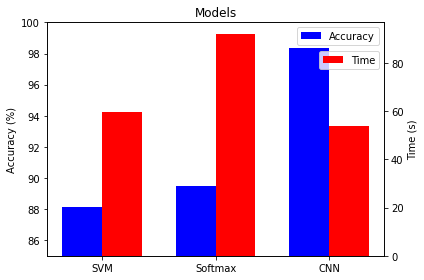

In [21]:
# Best SVM
best_svm_hyperparams = {'BatchSize': 100, 'Opt': torch.optim.SGD, 'OptParams': {'lr': 3.2e-4, 'momentum': 0.99}}
svm_model, svm_results = train_classifier(LinearSVM, best_svm_hyperparams)
svm_test_accuracy = get_test_accuracy(svm_model, test_dataset)
svm_time = svm_results['TimePerEpoch']*svm_results['NumEpochs']
# Best Softmax
best_softmax_hyperparams = {'BatchSize': 200, 'Opt': torch.optim.AdamW, 'OptParams': {'lr': 3.2e-4, 'amsgrad': True}}
softmax_model, softmax_results = train_classifier(SoftmaxClassifier, best_svm_hyperparams)
softmax_test_accuracy = get_test_accuracy(softmax_model, test_dataset)
softmax_time = softmax_results['TimePerEpoch']*softmax_results['NumEpochs']
# Best CNN
best_cnn_hyperparams = {'BatchSize': 100, 'Opt': torch.optim.AdamW, 'Loss': nn.CrossEntropyLoss(), 'OptParams': {'lr': 1e-3, 'amsgrad': True}}
cnn_model, cnn_time = train_cnn_classifier(CNN, best_cnn_hyperparams, 5, train_set, val_set)
cnn_test_accuracy = get_test_accuracy(cnn_model, test_dataset, conv=True)

# Create bar chart
labels = ['SVM', 'Softmax', 'CNN']
accuracies = [svm_test_accuracy, softmax_test_accuracy, cnn_test_accuracy]
times = [svm_time, softmax_time, cnn_time]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
ax2 = ax.twinx()

# Make bars
ax1 = ax.bar(x - width/2, accuracies, width, label='Accuracy', color='blue')
ax2.bar(x + width/2, times, width, label='Time', color='red')

# Format
ax.set_ylabel('Accuracy (%)')
ax.set_ylim([85, 100])
ax2.set_ylabel("Time (s)")
ax.set_title('Models')
ax.legend(bbox_to_anchor=(1,1))
ax2.legend(bbox_to_anchor=(1,0.9))
plt.xticks(np.arange(len(labels)), labels)

fig.tight_layout()

plt.show()


In the following cells ***write*** a short justification on how you came up with your final model and architecture. You may include details like:

- Which optimizer did you use? Why did you use that? 
- What about the other hyperparameters? 
- Did you base your model on an existing architecture?
- What changes did you make to improve accuracy?
- What changes did you make to improvde performance? 

***Include*** visualizations for the effect of different batch sizes, learning rates, and optimizers. You are free to choose any method of visualization as long as it is able to succintly convey your justifications. 

To determine the best model, I experimented using different hyperparameters for the SVM, Softmax, and CNN classifiers. 

For SVM/Softmax classifiers - I chose a batch size of 100/200 because it balanced accuracy with time per epoch - larger batches were slightly faster but had worse accuracy. For learning rate, I chose 3.2e-4 because larger values didn't decrease the number of epochs needed by much and were less accurate. SGD with momentum of 0.99 performed the best out of the 8 optimizers I tested, so I chose this one for SVM. For Softmax, the best optimizer was AdamW with AMSGrad.

The accuracy of the CNN models was significantly better than the best non-CNN models - accuracy for CNNs got into the high 90s vs high 80s for the linear classifiers. So, I chose to use a CNN for the final model and worked to achieve faster performence.
 - Batch norm on second convolution improved accuracy
 - Sigmoid as the last activation helped with minimal compute impact

Since less epochs were needed to get good accuracy with the CNN, the accuracy is higher than the SVM/Softmax classifiers and it achieves better runtime.



In [ ]:
# Visualizations for CNN - add

## Part 3: Real World Data (40 pts)

While test set accuracy is meant to approximate the perfomance in real world data, biases in data collection and processing often result in inaccurate performance estimates. In this section, you will be using the previously defined models to re-train on the data the class has collected. 

In user systems, noisy inputs are often likely. To make your model robust to faulty input, you will need to add an additional class to your model which corresponds to the label 10. This label is reserved for inputs that are **not** digits. 


***Implement*** the following cells to load and convert the new dataset and combine the new dataset with old dataset.  

Make sure you have downloaded the `MNIST580E_training.csv` and `MNIST580E_test.csv` files from the shared drive and uplodaded it to your GDrive. You will be combining our collected data with the MNIST dataset available with Colab.

You will need to: 


- Mount your GDrive
- Load the `MNIST580E_training.csv` and `MNIST580E_test.csv` files
- Parse the files and create train and test datasets as you did previously 
  - Make sure to normalize the data and add data augmentation. You are free to use any augmentation you'd like. 
- Combine the new datasets with the dataset available on Colab.
  - You can use the `ConcatDataset` or `ChainDataset`.  
- Visualize the newly created data. This should serve as a sanity check for your newly written data pipeline. 

**Data Augmentation:**

The collected data will have more variability compared to the original dataset. 
So you should make heavy use of data augmentation on the collected dataset. You can use augmentations such as as:

- Rotation
- Resize
- Blur
- Perspective shift

**Another hint:** Since we are adding an additional class type (not a digit), our dataset will be imbalanced. There will be fewer samples with that label compared to other labels. You may want to "double count" (i.e duplicate) the not-a-digit samples in your collected dataset.

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [42]:
import os
import matplotlib.image as img

def _drive_data_parser_helper(directory):
  X = []
  Y = []
  for filename in os.listdir(directory):
    filepath = os.path.join(directory, filename)
    class_type = int(filename.split('_')[0])
    picture = img.imread(filepath)
    num_counts = 1 if class_type < 10 else 2
    for cnt in range(num_counts):
      X.append(picture)
      Y.append(class_type)
  return (np.array(X), np.array(Y))

def get_drive_train_data():
  X_train, Y_train = _drive_data_parser_helper("drive/MyDrive/train")
  return X_train, Y_train

def get_drive_test_data():
  X_test, Y_test = _drive_data_parser_helper("drive/MyDrive/test")
  return X_test, Y_test

In [45]:
class DRIVE(Dataset):
  def __init__(self, is_training=True, transform=None):
    if is_training:
      x, y = get_drive_train_data()
    else:
      x, y = get_drive_test_data()
    self.images = torch.from_numpy(x).float()
    self.labels = torch.from_numpy(y)
    self.transform = transform

  def __len__(self):
    return len(self.images)

  def __getitem__(self, i):
    image = self.images[i]
    if self.transform:
      image = torch.reshape(image, (1,28,28))
      image = self.transform(image)
      image = torch.flatten(image[0, :, :])
    return image, self.labels[i]
  

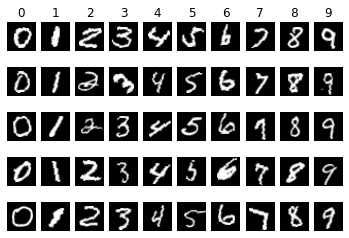

Combined dataset


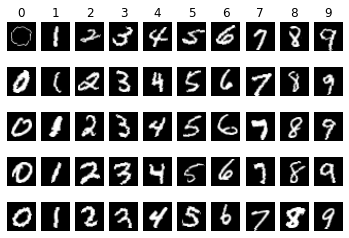

In [72]:
import torch.utils.data

transform_obj = transforms.Compose([
  transforms.RandomRotation(15),
  transforms.Normalize(0.13, 0.31),
])

train_dataset_drive = DRIVE(True, transform_obj)
test_dataset_drive = DRIVE(False, transform_obj)
visualize(train_dataset)

train_dataset_combine = torch.utils.data.ConcatDataset([train_dataset, train_dataset_drive])
test_dataset_combine = torch.utils.data.ConcatDataset([test_dataset, test_dataset_drive])
print("Combined dataset")
visualize(train_dataset_combine)

train_num = int(len(train_dataset_combine) * 0.8)
val_num = len(train_dataset_combine) - train_num
train_set_combine, val_set_combine = torch.utils.data.random_split(train_dataset_combine, [train_num, val_num])


**Implement** the following cell to use your previously trained CNN as a feature extractor. This is an example of [transfer learning](https://en.wikipedia.org/wiki/Transfer_learning). 

You will need to:
- Freeze the layers of convolutional model you trained
- Change the final linear layer have an additional output for the additional class.  

Here's an example of taking the previously defined LeNet and updating the final layer to have 11 classes instead of 10. This also freezes the other weights in the LeNet. 

```python
# model_conv is a trained LeNet example from above

# Freeze the weights of the model
# The gradients will not be calculated and the optimizer will not
# update the weights
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc3.in_features
model_conv.fc3 = nn.Linear(num_ftrs, 11)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Only parameters of final layer are being optimized not the other weights
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001)
```


In [77]:
best_cnn_hyperparams = {'BatchSize': 100, 'Opt': torch.optim.AdamW, 'Loss': nn.CrossEntropyLoss(), 'OptParams': {'lr': 1e-3, 'amsgrad': True}}
cnn_model, cnn_time = train_cnn_classifier(CNN, best_cnn_hyperparams, 5, train_set, val_set)
cnn_test_accuracy = get_test_accuracy(cnn_model, test_dataset, conv=True)
print(cnn_test_accuracy)

# Freeze weights
for param in cnn_model.parameters():
  param.requires_grad = False

num_features = cnn_model.fc3.in_features
cnn_model.fc3 = nn.Linear(num_features, 11)



98.11999999999999
94.57357075913777


**Implement** the following cell to train the final layer of the convolution. Also calculate the test set performance on this fine-tuned model. 

In [ ]:
train_cnn_classifier(CNN, best_cnn_hyperparams, 1, train_set_combine, val_set_combine, starting_model=cnn_model)

cnn_test_accuracy = get_test_accuracy(cnn_model, test_dataset_combine, conv=True)
print(cnn_test_accuracy)

***Implement*** the following cell to retrain the linear classifiers (LinearSVM and Softmax). Note that you have an extra class as your model should also detect "not a digit". 

***Implement*** the following cell to retrain your previously defined CNN model. 

**Implement** a visualization of the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) on the **new** combined test set with the predictions from your LinearSVM, Softmax, and CNN. You should use a single `Matplotlib` figure with multiple subplots on a single row. 

[See here for examples on using plt.subplots.](https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html)

In the following cells, write a short report about the performance of your models. You should include the effects of new data, data augmentation, and different architectures. You should also include visualizations as you did before. 